## AISE4010- Project - Time Series Forecasting On Air Quality in Bejing

Aidan Bugler - 251278536

Paige Mighton - 251280923 

Alexis Lovell Morrison - 2513034567

Ben Viveiros - 251239396

### Dataset Processing

Dataset sample:
                     No  year  month  day  hour  season  PM_Dongsi  \
datetime                                                             
2010-01-01 00:00:00   1  2010      1    1     0       4        NaN   
2010-01-01 01:00:00   2  2010      1    1     1       4        NaN   
2010-01-01 02:00:00   3  2010      1    1     2       4        NaN   
2010-01-01 03:00:00   4  2010      1    1     3       4        NaN   
2010-01-01 04:00:00   5  2010      1    1     4       4        NaN   

                     PM_Dongsihuan  PM_Nongzhanguan  PM_US Post  DEWP  HUMI  \
datetime                                                                      
2010-01-01 00:00:00            NaN              NaN         NaN -21.0  43.0   
2010-01-01 01:00:00            NaN              NaN         NaN -21.0  47.0   
2010-01-01 02:00:00            NaN              NaN         NaN -21.0  43.0   
2010-01-01 03:00:00            NaN              NaN         NaN -21.0  55.0   
2010-01-01 04:00:00

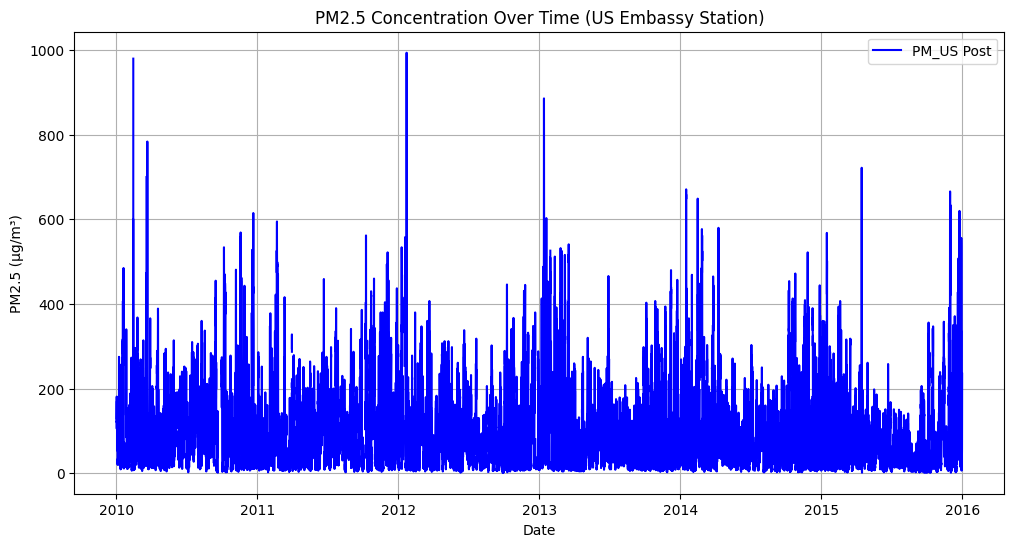

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Beijing.csv')

# Combine date components into a single datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as the index and sort
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print('Dataset sample:')
print(df.head())
plt.figure(figsize=(12,6))
plt.plot(df.index, df['PM_US Post'], label='PM_US Post', color='blue')
plt.title('PM2.5 Concentration Over Time (US Embassy Station)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend()
plt.show()

### Data Preprocessing

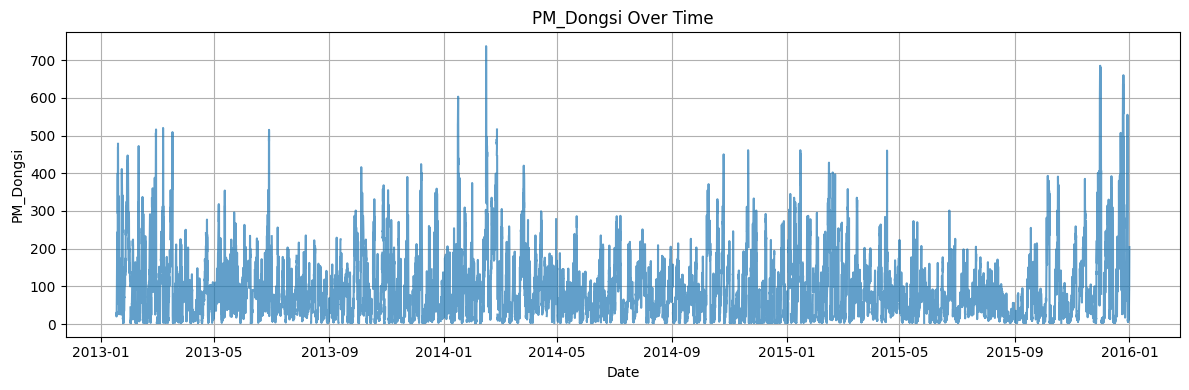

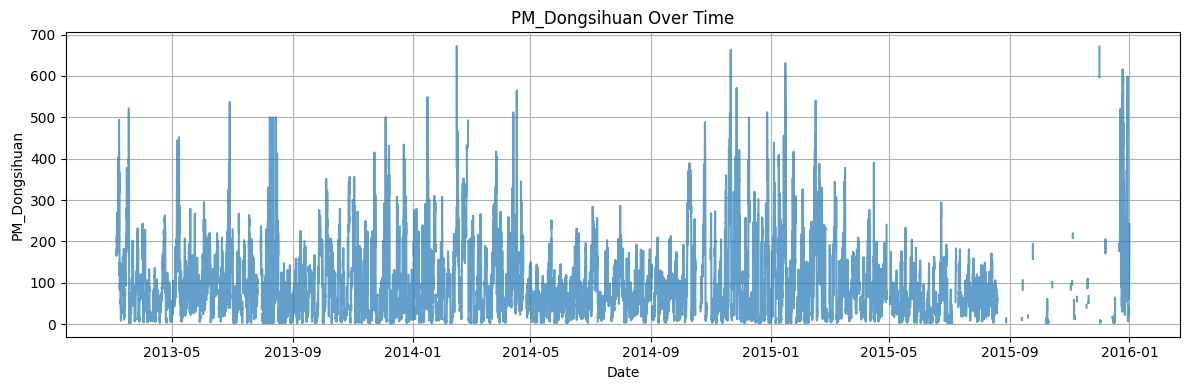

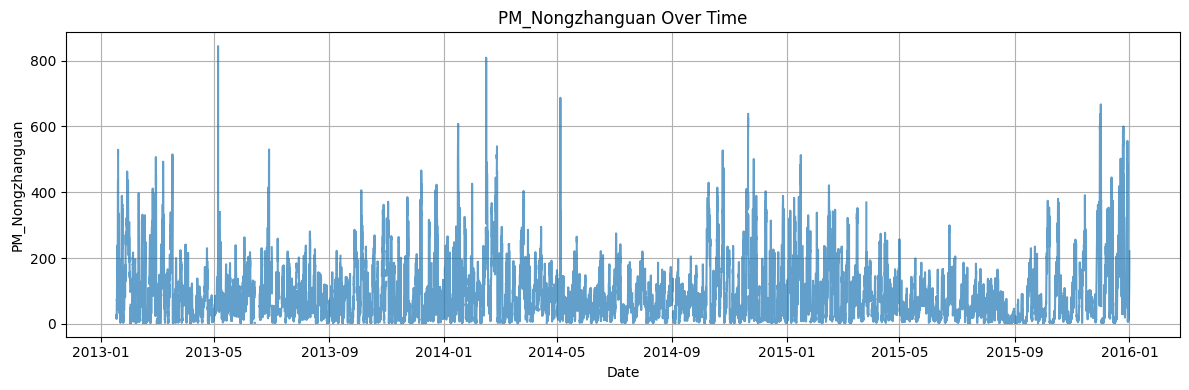

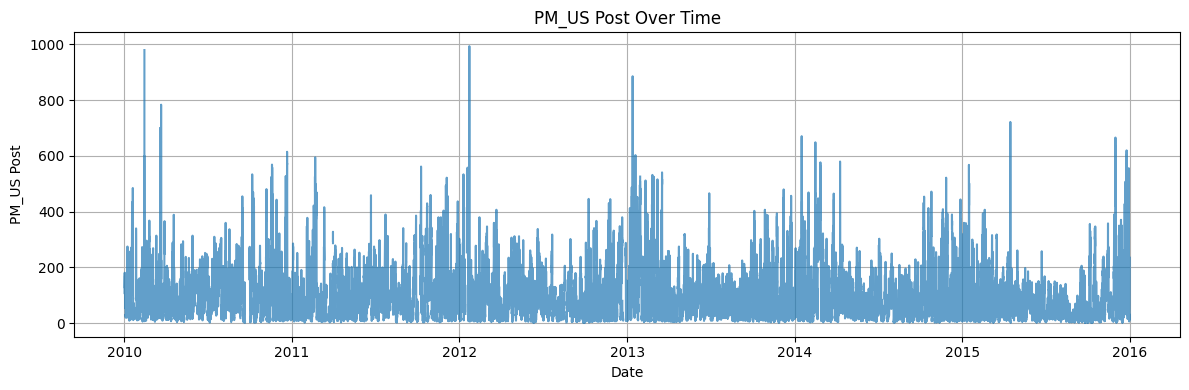

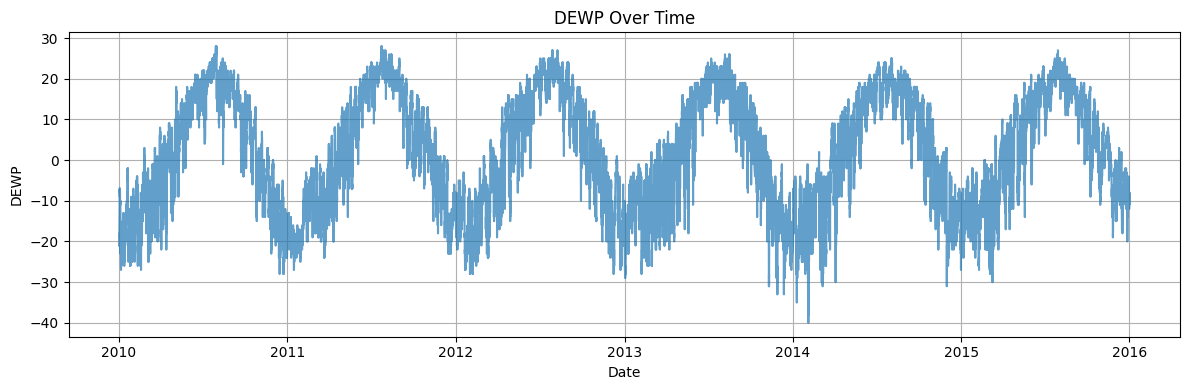

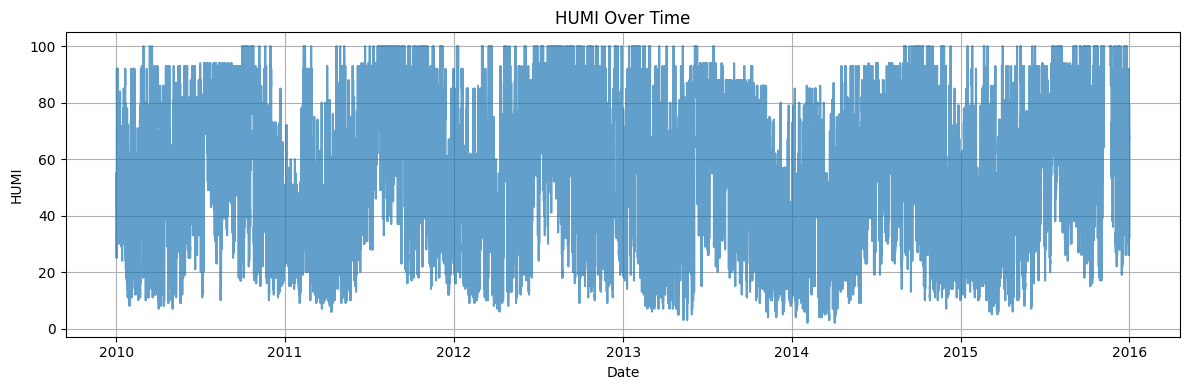

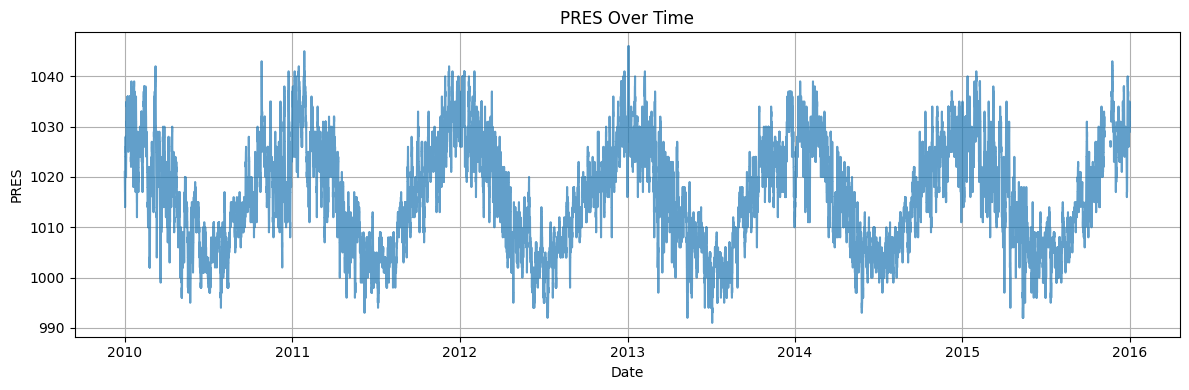

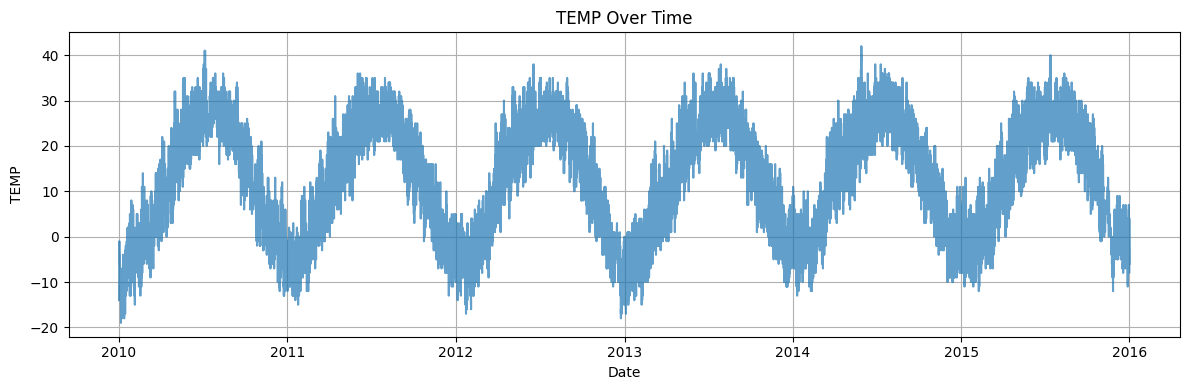

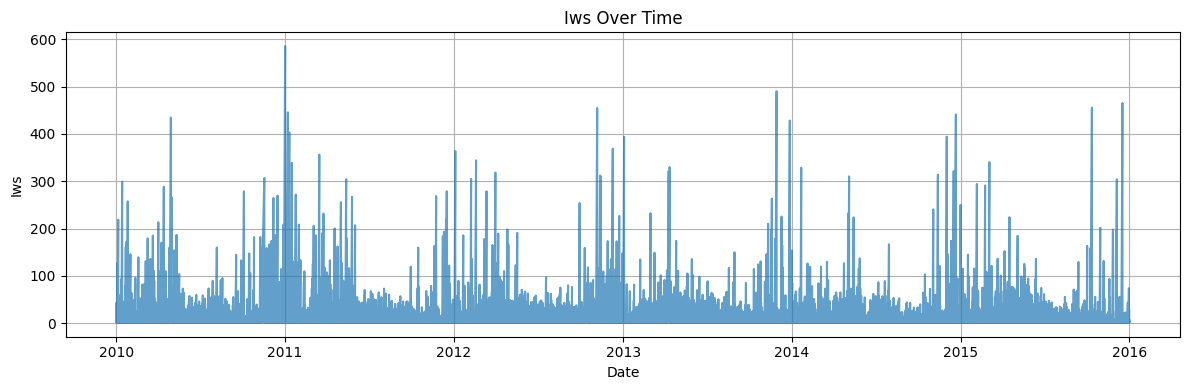

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Beijing.csv')

# Combine date components into a single datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as the index and sort
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Select all numeric columns except the year/month/day/hour columns
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in ['year','month','day','hour']]
numeric_cols = numeric_cols[2:-2]

# ---- Plot each variable individually ----
for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[col], alpha=0.7)
    plt.title(f"{col} Over Time")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Handling Missing Values Through Interpolation, Checking for Duplicates, OHE, Smoothing

In [44]:
# Combine date columns into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Handle missing values
numeric_cols = ['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post',
                'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'Iprec']

# Interpolate numeric columns by time
df[numeric_cols] = df[numeric_cols].interpolate(method='time')

# Forward fill categorical column
df['cbwd'].fillna(method='ffill', inplace=True)

# Drop any remaining NaNs
df.dropna(inplace=True)

print("Missing values handled. Remaining NaNs per column:")
print(df.isna().sum())

Missing values handled. Remaining NaNs per column:
No                 0
year               0
month              0
day                0
hour               0
season             0
PM_Dongsi          0
PM_Dongsihuan      0
PM_Nongzhanguan    0
PM_US Post         0
DEWP               0
HUMI               0
PRES               0
TEMP               0
cbwd               0
Iws                0
precipitation      0
Iprec              0
dtype: int64


C:\Users\bvive\AppData\Local\Temp\ipykernel_19884\939051922.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cbwd'].fillna(method='ffill', inplace=True)
C:\Users\bvive\AppData\Local\Temp\ipykernel_19884\939051922.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cbwd'].fillna(method='ffill', inplace=True)


In [45]:
# Remove duplicate timestamps in case
before = len(df)
df = df[~df.index.duplicated(keep='first')]
after = len(df)
print(f"Removed {before - after} duplicate rows. Remaining rows: {after}")

Removed 0 duplicate rows. Remaining rows: 24760


In [46]:
# One-hot encode wind direction (cbwd)
df = pd.get_dummies(df, columns=['cbwd'], prefix='cbwd')
print("Categorical variable 'cbwd' encoded.")
print("New columns:", [col for col in df.columns if 'cbwd_' in col])


Categorical variable 'cbwd' encoded.
New columns: ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


In [47]:
# --- Apply smoothing only to correct variables for model input ---
smooth_vars = [
    'PM_US Post', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan',
    'TEMP', 'DEWP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec'
]

window = 5  # smoothing window

for col in smooth_vars:
    df[col + '_smooth'] = df[col].rolling(window=window, center=True).mean()
    df[col + '_smooth'].fillna(df[col], inplace=True)

# Optionally replace original columns with smoothed ones for model training
for col in smooth_vars:
    df[col] = df[col + '_smooth']

C:\Users\bvive\AppData\Local\Temp\ipykernel_19884\1970590686.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col + '_smooth'].fillna(df[col], inplace=True)
C:\Users\bvive\AppData\Local\Temp\ipykernel_19884\1970590686.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

### Splitting Data for Training & Testing

In [48]:
import numpy as np

target = 'PM_US Post'
features = ['year', 'month', 'day', 'hour', 'season',
            'DEWP', 'TEMP', 'HUMI', 'PRES',
            'Iws', 'precipitation', 'Iprec', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Convert to arrays #
# Ensure all columns are numeric
data = df[features + [target]].astype(np.float32).values
window_size = 10

# Sliding window
def sliding_window(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :-1])  #all features except target
        y.append(data[i+window, -1])     #only the target column
    return np.array(X), np.array(y)

X, y = sliding_window(data, window_size)

# Split into 80% training and 20% testing 
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"# of sequences in training samples: {len(X_train)}")
print(f"# of sequences in testing samples: {len(X_test)}")
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# of sequences in training samples: 19800
# of sequences in testing samples: 4950
X_train shape: (19800, 10, 16)
y_train shape: (19800,)
X_test shape: (4950, 10, 16)
y_test shape: (4950,)


### Decomposition

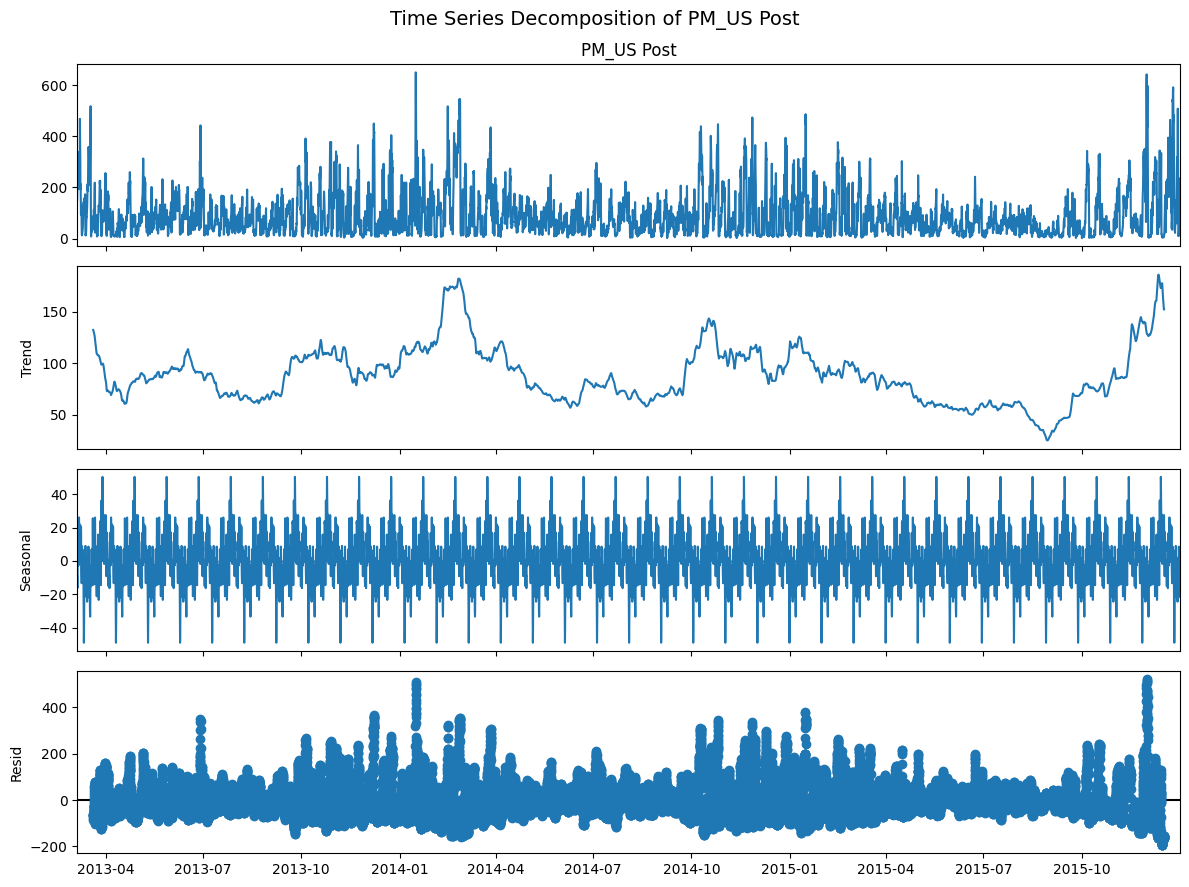

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_col = 'PM_US Post'

# Perform additive decomposition
# Period is monthly !!!! i think 
decomposition = seasonal_decompose(df[target_col], model='additive', period=720)

plt.rcParams.update({'figure.figsize': (12, 9)})
decomposition.plot()
plt.suptitle(f'Time Series Decomposition of {target_col}', fontsize=14)
plt.tight_layout()
plt.show()


#### SMOOTHING

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Normalize SEQUENCE DATA for all deep models

# Standardize X (features), MinMax scale y (target)
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

# Flatten X_train/X_test over time dimension for fitting scaler
n_train, w, n_feat = X_train.shape
n_test = X_test.shape[0]

X_train_flat = X_train.reshape(-1, n_feat)
X_test_flat = X_test.reshape(-1, n_feat)

# Fit on TRAIN only to avoid data leakage
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

# Reshape back to 3D [samples, window, features]
X_train_scaled = X_train_scaled_flat.reshape(n_train, w, n_feat)
X_test_scaled = X_test_scaled_flat.reshape(n_test, w, n_feat)

# Scale y (target) using TRAIN only
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

print("Sequence normalization complete: X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled ready.")

Sequence normalization complete: X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled ready.


### LSTM


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Create function that builds LSTM model with 2 LSTM layers & dropout
def build_lstm_model(units1=64, units2=32, dropout=0.3, lr=0.0005):
    model = Sequential([
        # First LSTM layer returns sequences so next LSTM can process time steps
        LSTM(units1, activation='tanh', return_sequences=True,
             input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        # Dropout to prevent overfitting
        Dropout(dropout),
        # Second LSTM layer returns final output only
        LSTM(units2, activation='tanh'),
        # Dropout again to prevent overfitting
        Dropout(dropout),
        # Dense output layer (1 unit for regression)
        Dense(1)
    ])
    # Fit mse loss and apply Adam optimizer
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


In [52]:
import numpy as np
#$ preset parameters to optimize the model
param_grid = [
    {"units1": 32,  "units2": 16, "dropout": 0.2, "lr": 0.001,  "batch_size": 32},
    {"units1": 64,  "units2": 32, "dropout": 0.3, "lr": 0.0005, "batch_size": 32},
    {"units1": 128, "units2": 64, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},
    {"units1": 64,  "units2": 32, "dropout": 0.5, "lr": 0.0005, "batch_size": 32},
]


In [53]:
best_config = None
best_val_loss = np.inf
best_model = None
best_history = None

# Loop through each hyperparameter combination in the grid
for idx, p in enumerate(param_grid):

    # Print which config is running
    print(f"\n=== LSTM Config {idx+1}/{len(param_grid)}: {p} ===")

    # Build LSTM model using the current hyperparameters
    model = build_lstm_model(
        units1=p["units1"],   # First LSTM layer size
        units2=p["units2"],   # Second LSTM layer size
        dropout=p["dropout"], # Dropout rate for regularization
        lr=p["lr"]            # Learning rate for Adam optimizer
    )
    
    # Train the model with current settings
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=25,                 # Fixed number of training epochs
        batch_size=p["batch_size"],# Batch size from hyperparameters
        validation_split=0.2,      # 20% of training data for validation
        verbose=0                  # Silent training (set 1 to see logs)
    )
    
    # Grab the final validation loss for comparison
    val_loss = history.history["val_loss"][-1]
    print("Final val_loss:", val_loss)

    # If current model is best so far, save its details
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = p
        best_model = model
        best_history = history

# Print the best hyperparameters and validation performance
print("\nBest LSTM hyperparameters:", best_config)
print("Best LSTM validation loss:", best_val_loss)

# Save tuned model for later evaluation
lstm_model = best_model



=== LSTM Config 1/4: {'units1': 32, 'units2': 16, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ===


c:\Users\bvive\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final val_loss: 0.01650894060730934

=== LSTM Config 2/4: {'units1': 64, 'units2': 32, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.012095348909497261

=== LSTM Config 3/4: {'units1': 128, 'units2': 64, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64} ===
Final val_loss: 0.015321094542741776

=== LSTM Config 4/4: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.007624599616974592

Best LSTM hyperparameters: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}
Best LSTM validation loss: 0.007624599616974592


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 76.58411
MAE: 49.350307
R²: 0.3384590744972229


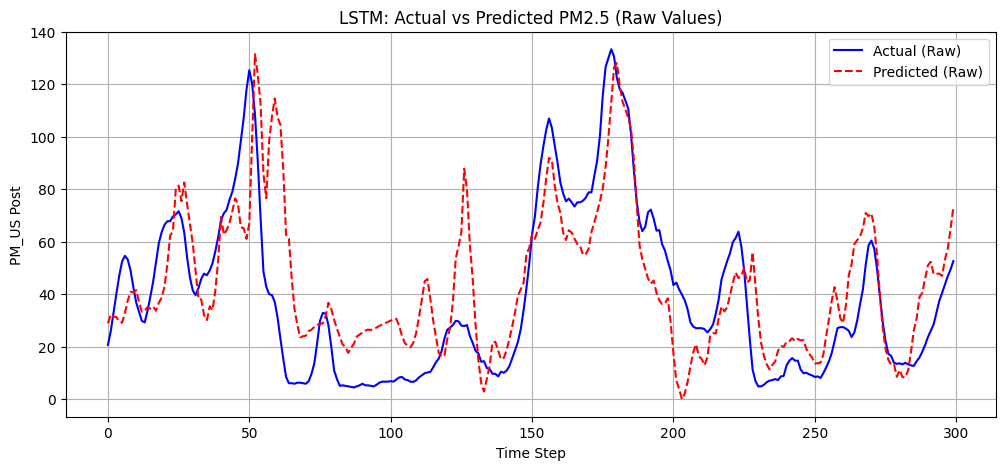

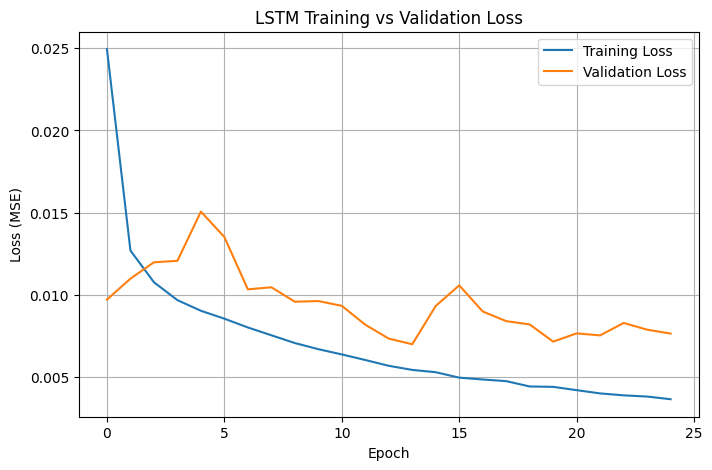

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Predict using LSTM model ---
#Flatten so predictions are a simple 1D array
y_pred_scaled = lstm_model.predict(X_test_scaled).flatten()

# --- Convert predictions + true values back to original scale ---
#Scaler expects 2D, so reshape then flatten after inverse transform
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true_raw = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

# --- Compute evaluation metrics on raw values ---
rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))  # Root Mean Squared Error
mae = mean_absolute_error(y_true_raw, y_pred_raw)           # Mean Absolute Error
r2 = r2_score(y_true_raw, y_pred_raw)                       # R² score

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# --- Plot Actual vs Predicted (raw scale) ---
plt.figure(figsize=(12,5))
plt.plot(y_true_raw[:300], label="Actual (Raw)", color='blue')     # First 300 actual values
plt.plot(y_pred_raw[:300], label="Predicted (Raw)", color='red', linestyle='--')
plt.title("LSTM: Actual vs Predicted PM2.5 (Raw Values)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training vs Validation Loss curves ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')        # MSE on training
plt.plot(history.history['val_loss'], label='Validation Loss')  # MSE on validation split
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


### RNN

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_rnn_model(units1=64, units2=32, dropout=0.3, lr=0.0005):
    # Building Sequential RNN model
    model = Sequential([
        # For the first SimpleRNN layer...
        # -units1: number of recurrent units
        # -return_sequences=True to pass full sequence to the next RNN layer
        # -input_shape uses the shape of the scaled training data
        SimpleRNN(
            units1,
            activation='tanh',
            return_sequences=True,
            input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
        ),
        # Dropout layer to reduce overfitting by randomly disabling neurons
        Dropout(dropout),
        # Second SimpleRNN layer
        # - Last recurrent layer, so return_sequences=False (default)
        SimpleRNN(
            units2,
            activation='tanh'
        ),
        # Another dropout layer for regularization
        Dropout(dropout),
        # Output layer with a single neuron for regression prediction
        Dense(1)
    ])
    # Compile model with Adam optimizer and MSE loss for regression
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )

    # Return the constructed and compiled model
    return model

In [56]:
# Four different hyper parameters pre-set
param_grid = [
    {"units1": 32, "units2": 16, "dropout": 0.2, "lr": 0.001,  "batch_size": 32},
    {"units1": 64, "units2": 32, "dropout": 0.3, "lr": 0.0005, "batch_size": 32},
    {"units1": 128,"units2": 64, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},
    {"units1": 64, "units2": 32, "dropout": 0.5, "lr": 0.0005, "batch_size": 32},
]



=== Config 1/4: {'units1': 32, 'units2': 16, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ===


c:\Users\bvive\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final val_loss: 0.010183150880038738

=== Config 2/4: {'units1': 64, 'units2': 32, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.013096418231725693

=== Config 3/4: {'units1': 128, 'units2': 64, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64} ===
Final val_loss: 0.013404961675405502

=== Config 4/4: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.008411276154220104

Best hyperparameters: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}
Best validation loss: 0.008411276154220104


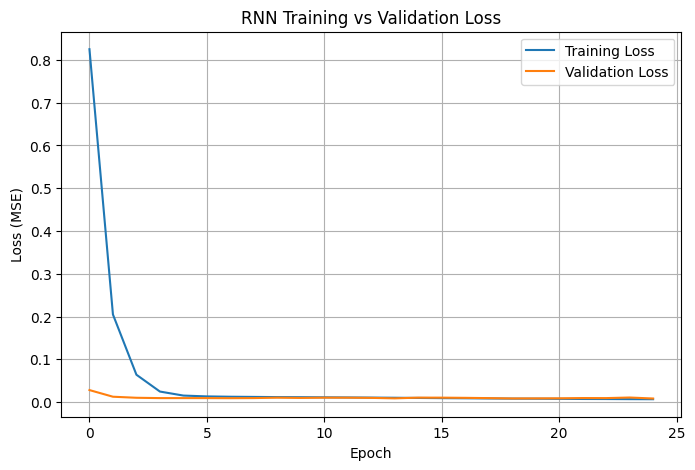

In [57]:
import numpy as np

# Variables to track the best hyperparameter configuration and results
best_config = None
best_val_loss = np.inf   # Initialize with infinity so any real loss is lower
best_model = None
best_history = None

# Looping through each hyperparameter configuration in the param grid above ^
for idx, p in enumerate(param_grid):
    print(f"\n=== Config {idx+1}/{len(param_grid)}: {p} ===")
    
    # Build a model using the current hyperparameter configuration
    model = build_rnn_model(
        units1=p["units1"],
        units2=p["units2"],
        dropout=p["dropout"],
        lr=p["lr"]
    )
    
    # Train the model on the training set with a validation split
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=25,
        batch_size=p["batch_size"],
        validation_split=0.2,   # 20% of training data used for validation
        verbose=0               # Silent training
    )
    
    # Getting the final validation loss from this training run
    val_loss = history.history["val_loss"][-1]
    print("Final val_loss:", val_loss)

    # Checking if this model achieved the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = p
        best_model = model
        best_history = history

# Print the best found hyperparameters and validation performance
print("\nBest hyperparameters:", best_config)
print("Best validation loss:", best_val_loss)

# Save the best model so we can  compair it later
rnn_model = best_model

# Plot training vs validation loss for the last training run
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("RNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 80.04893
MAE: 54.78601
R²: 0.27724605798721313


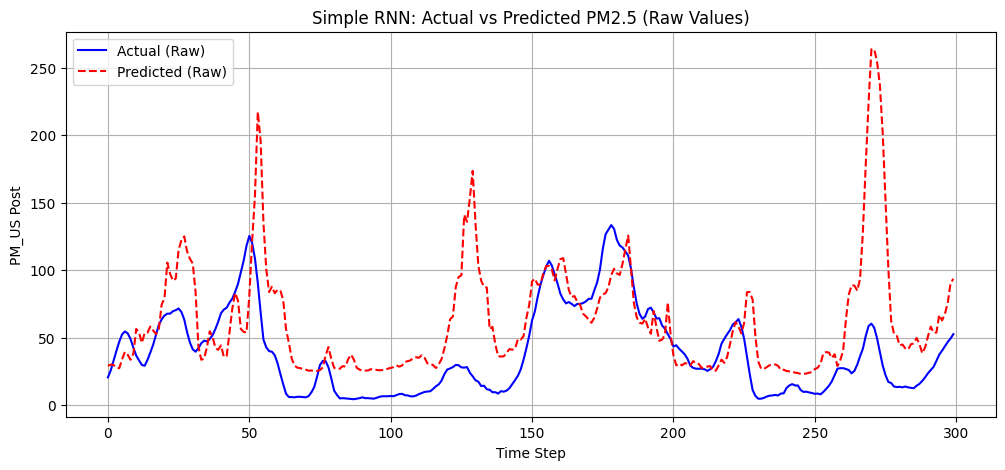

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predicting using the Simple RNN model
# Generate predictions on the scaled test set
y_pred_scaled = rnn_model.predict(X_test_scaled).flatten()

# Converting predictions and true values back to raw PM2.5 scale
# Inverse transform to return predicted values to original units
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# Inverse transform the true test labels as well
y_true_raw = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

# Metrics of success in raw scale
# RMSE: Root Mean Squared Error between actual and predicted values
rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))

# MAE: Mean Absolute Error
mae = mean_absolute_error(y_true_raw, y_pred_raw)

# R² Score: coefficient of determination (goodness of fit :P)
r2 = r2_score(y_true_raw, y_pred_raw)

# Print the evaluation metrics
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# Plot raw actual vs predicted
plt.figure(figsize=(12,5))

# Plot first 300 time steps of actual PM2.5 values (Blue)
plt.plot(y_true_raw[:300], label="Actual (Raw)", color='blue')

# Plot first 300 predicted PM2.5 values (Dashed red)
plt.plot(y_pred_raw[:300], label="Predicted (Raw)", color='red', linestyle='--')

# Add plot title and axis labels
plt.title("Simple RNN: Actual vs Predicted PM2.5 (Raw Values)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")

# Display legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### GRU

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Create function that builds GRU model with 2 GRU layers & dropout 
def build_gru_model(units1=64, units2=32, dropout=0.3, lr=0.0005):
    model = Sequential([
        #First layer returns sequences so next GRU can process time steps
        GRU(units1, activation='tanh', return_sequences=True,
            input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        #Dropout to prevent overfitting
        Dropout(dropout),
        #2nd GRU layer returns final output
        GRU(units2, activation='tanh'),
        #Dropout again to prevent overfitting
        Dropout(dropout),
        #Dense output layer (1 unit for regression)
        Dense(1)
    ])
    #Find mse less and implement Adam optimizer
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


 

In [60]:
import numpy as np

#Grid of hyperparameters to test
param_grid = [
    {"units1": 32,  "units2": 16, "dropout": 0.2, "lr": 0.001,  "batch_size": 32},
    {"units1": 64,  "units2": 32, "dropout": 0.3, "lr": 0.0005, "batch_size": 32},
    {"units1": 128, "units2": 64, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},
    {"units1": 64,  "units2": 32, "dropout": 0.5, "lr": 0.0005, "batch_size": 32},
]



=== GRU Config 1/4: {'units1': 32, 'units2': 16, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ===


c:\Users\bvive\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final val_loss: 0.009591354057192802

=== GRU Config 2/4: {'units1': 64, 'units2': 32, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.008696275763213634

=== GRU Config 3/4: {'units1': 128, 'units2': 64, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64} ===
Final val_loss: 0.008611281402409077

=== GRU Config 4/4: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.008278789930045605

Best GRU hyperparameters: {'units1': 64, 'units2': 32, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}
Best GRU validation loss: 0.008278789930045605


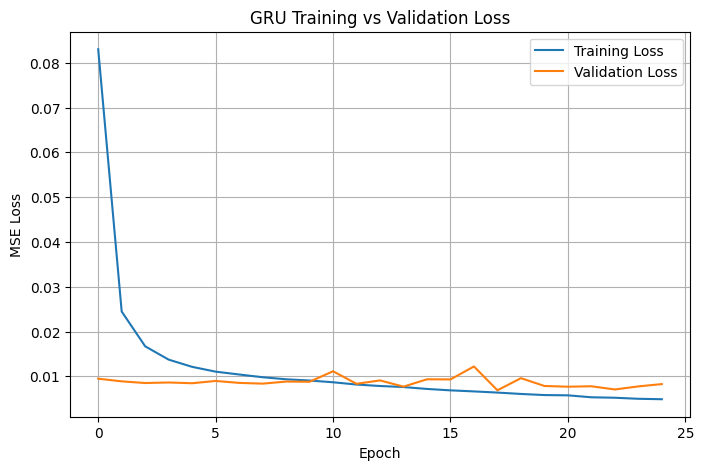

In [61]:
#Variables for tracking best configuration
best_config = None
best_val_loss = np.inf
best_model = None
best_history = None

#Loop through each set of hyperoarameters
for idx, p in enumerate(param_grid):
    print(f"\n=== GRU Config {idx+1}/{len(param_grid)}: {p} ===")
    
    #Build each model using current hyperparameter set
    model = build_gru_model(
        units1=p["units1"],
        units2=p["units2"],
        dropout=p["dropout"],
        lr=p["lr"]
    )
    
    #Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=25,
        batch_size=p["batch_size"], 
        validation_split=0.2,
        verbose=0  #Change to 1 if you want to see epochs
    )
    
    #Get final valuidation loss from this run
    val_loss = history.history["val_loss"][-1]
    print("Final val_loss:", val_loss)

    #Update best model if this configuration performed better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = p
        best_model = model
        best_history = history

#Print best hyperparamters & validation loss
print("\nBest GRU hyperparameters:", best_config)
print("Best GRU validation loss:", best_val_loss)

#Final chosen GRU model
gru_model = best_model

#plot training vs validation loss history 
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("GRU Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE: 70.44317
MAE: 46.613728
R²: 0.44029760360717773


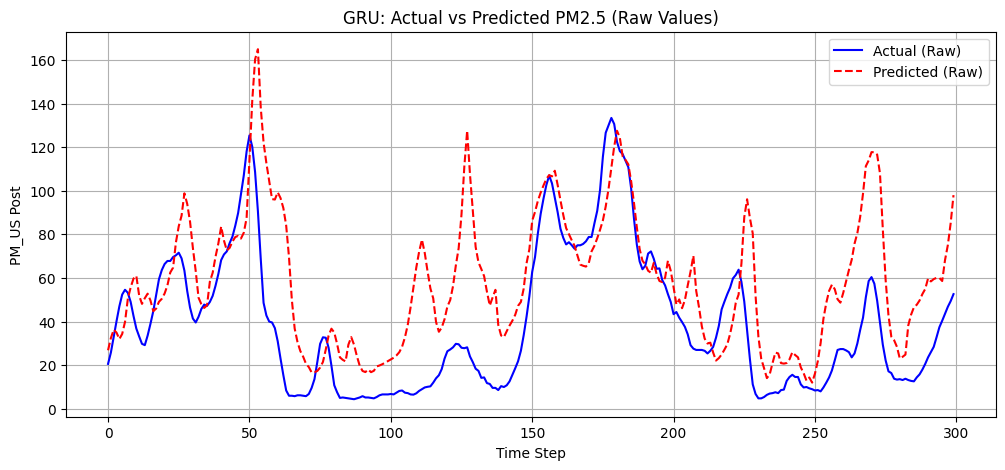

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
 
#Predict using the best GRU model found before
y_pred_scaled = gru_model.predict(X_test_scaled).flatten()
 
#Convert scaled predictions original PM2.5 values
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true_raw = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
 
#Calculate metrics in original scale
rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
mae = mean_absolute_error(y_true_raw, y_pred_raw)
r2 = r2_score(y_true_raw, y_pred_raw)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 
#Plot raw actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_true_raw[:300], label="Actual (Raw)", color='blue')
plt.plot(y_pred_raw[:300], label="Predicted (Raw)", color='red', linestyle='--')
plt.title("GRU: Actual vs Predicted PM2.5 (Raw Values)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()


### Transformer

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.optimizers import Adam

def transformer_block(x, num_heads, key_dim, ff_dim, dropout):
    #Self-attention block 
    #apply the multi-head attention which the model learns relationships between all the timesteps & features
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output) #for regularization to prevent overfitting
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output) #add original input (x) to the attention layer before normalizing
    #Residual + layer normalization

    #Feed Forward Block
    ff_output = Dense(ff_dim, activation='relu')(out1) #first dense layer expands the representation
    ff_output = Dense(x.shape[-1])(ff_output) #second dense layer projects back to the original input dimensions
    ff_output = Dropout(dropout)(ff_output) #To reduce overfitting
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff_output) #add output of Feed-forward block to the residual output
    return out2


def build_transformer_model(num_heads=4, key_dim=16, ff_dim=64, dropout=0.3, lr=0.0005):
    #Input shape is (timesteps, features)
    #Get the shape from X_train_scaled to match the dataset
    inputs = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    
    x = transformer_block(inputs, num_heads, key_dim, ff_dim, dropout)
    #adding one transformer encoder block
    
    x = Flatten()(x) #flatten all timesteps & features into a single vector
    x = Dense(64, activation='relu')(x) #Dense layer for further learning
    x = Dropout(dropout)(x) #to prevent overfitting
    outputs = Dense(1)(x) #single regression value

    model = Model(inputs=inputs, outputs=outputs) #BUilding the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    #Compile the model using Adam optimizer & MSE loss for regression
    return model

In [64]:
import numpy as np

#Hyperparameter search grid
#Each dictionary represents 1 transformer configuration to be tested

param_grid = [
    {"num_heads": 2, "key_dim": 16, "ff_dim": 64,  "dropout": 0.2, "lr": 0.001,  "batch_size": 32},
    {"num_heads": 4, "key_dim": 16, "ff_dim": 128, "dropout": 0.3, "lr": 0.0005, "batch_size": 32},
    {"num_heads": 4, "key_dim": 32, "ff_dim": 128, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},
    {"num_heads": 8, "key_dim": 32, "ff_dim": 256, "dropout": 0.5, "lr": 0.0003, "batch_size": 32},
]


=== Transformer Config 1/4: {'num_heads': 2, 'key_dim': 16, 'ff_dim': 64, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32} ===
Final val_loss: 0.008990361355245113

=== Transformer Config 2/4: {'num_heads': 4, 'key_dim': 16, 'ff_dim': 128, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32} ===
Final val_loss: 0.007420417852699757

=== Transformer Config 3/4: {'num_heads': 4, 'key_dim': 32, 'ff_dim': 128, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64} ===
Final val_loss: 0.007420127745717764

=== Transformer Config 4/4: {'num_heads': 8, 'key_dim': 32, 'ff_dim': 256, 'dropout': 0.5, 'lr': 0.0003, 'batch_size': 32} ===
Final val_loss: 0.006729342509061098

Best Transformer hyperparameters: {'num_heads': 8, 'key_dim': 32, 'ff_dim': 256, 'dropout': 0.5, 'lr': 0.0003, 'batch_size': 32}
Best Transformer validation loss: 0.006729342509061098


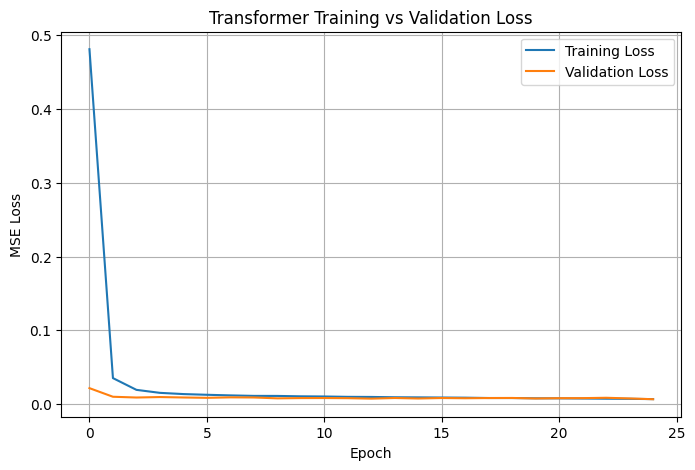

In [65]:
#Tracking the best model
best_config = None #stores the best hyperparameter set
best_val_loss = np.inf #intialize the best loss to infinity
best_model = None #best transformer model
best_history = None #best training history (loss curves)

#Looping through each hyperparameter configuration
for idx, p in enumerate(param_grid):
    print(f"\n=== Transformer Config {idx+1}/{len(param_grid)}: {p} ===")
    
    #Build a transformer using the current hyperparameters
    model = build_transformer_model(
        num_heads=p["num_heads"],
        key_dim=p["key_dim"],
        ff_dim=p["ff_dim"],
        dropout=p["dropout"],
        lr=p["lr"]
    )
    #Train the model 
    #Validation split of 20% of training data 
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=25,
        batch_size=p["batch_size"],
        validation_split=0.2,
        verbose=0
    )
    
    #Use the final validation loss of this run to compare models
    val_loss = history.history["val_loss"][-1]
    print("Final val_loss:", val_loss)

    #Update the best model if the current model is better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = p
        best_model = model
        best_history = history

#Print the best hyperparamter & validation loss found
print("\nBest Transformer hyperparameters:", best_config)
print("Best Transformer validation loss:", best_val_loss)

#Tuned model used for testing & prediction
transformer_model = best_model

#Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Transformer Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE: 65.589775
MAE: 41.682323
R²: 0.5147654414176941


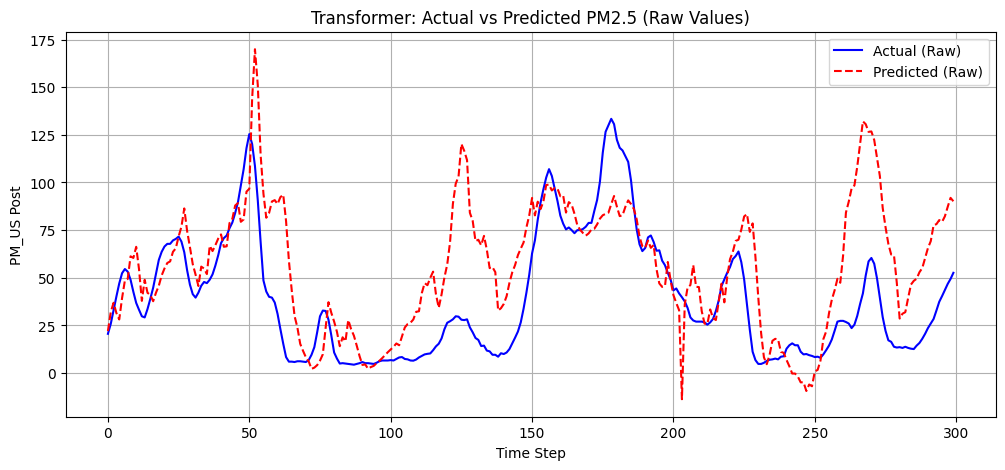

In [66]:
#Model Evaluation 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#Predict on test set (scaled values)
y_pred_scaled = transformer_model.predict(X_test_scaled).flatten()

#Inverse transform to original PM2.5 units
#access scaler for y-target & convert predicted & true values back 
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true_raw = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

#Compute metrics on raw scale
rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
mae = mean_absolute_error(y_true_raw, y_pred_raw)
r2 = r2_score(y_true_raw, y_pred_raw)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

#Plot raw actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_true_raw[:300], label="Actual (Raw)", color='blue')
plt.plot(y_pred_raw[:300], label="Predicted (Raw)", color='red', linestyle='--')
plt.title("Transformer: Actual vs Predicted PM2.5 (Raw Values)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

### Anomaly

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Detected 105 anomalies


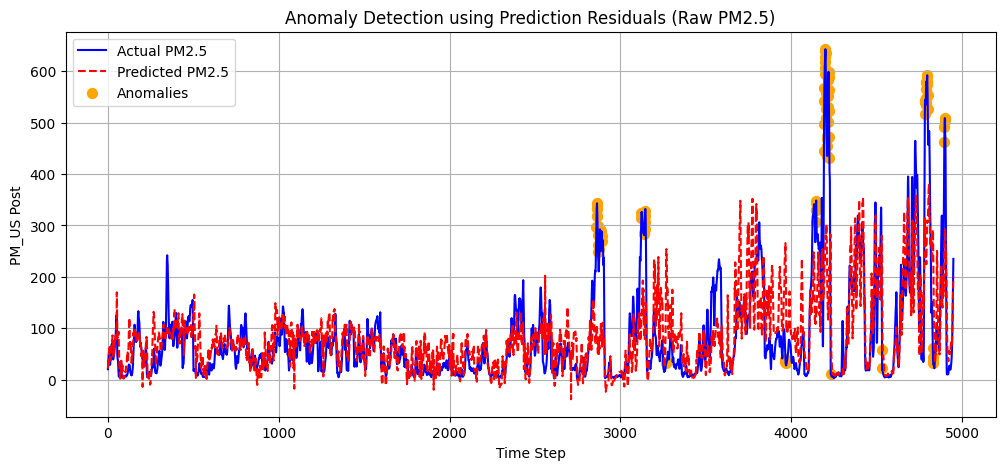

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# --- Predict using the trained model (e.g., TCN) ---
y_pred_scaled = model.predict(X_test_scaled).flatten()

# --- Convert predictions and true values back to raw PM2.5 scale ---
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

# --- Compute residuals ---
residuals = y_true - y_pred
mean_res = np.mean(residuals)
std_res = np.std(residuals)

# --- Define anomaly thresholds (3-sigma) ---
upper_limit = mean_res + 3*std_res
lower_limit = mean_res - 3*std_res

# --- Detect anomalies ---
anomalies = (residuals > upper_limit) | (residuals < lower_limit)
anomaly_indices = np.where(anomalies)[0]

print(f"Detected {len(anomaly_indices)} anomalies")

# --- Plot raw PM2.5, predictions, and anomalies ---
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual PM2.5", color='blue')
plt.plot(y_pred, label="Predicted PM2.5", color='red', linestyle='--')
plt.scatter(anomaly_indices, y_true[anomaly_indices], color='orange', label="Anomalies", s=50)
plt.title("Anomaly Detection using Prediction Residuals (Raw PM2.5)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

def eval_model(name, model, X_test_scaled, y_test_scaled, scaler_y):
    """Evaluate a model in RAW PM2.5 scale and store RMSE, MAE, R²."""
    try:
        # Predict in scaled space
        y_pred_scaled = model.predict(X_test_scaled).reshape(-1, 1)

        # Back to raw scale
        y_pred_raw = scaler_y.inverse_transform(y_pred_scaled).flatten()
        y_true_raw = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

        rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
        mae  = mean_absolute_error(y_true_raw, y_pred_raw)
        r2   = r2_score(y_true_raw, y_pred_raw)

        results.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })
    except Exception as e:
        print(f"[{name}] Error during evaluation:", e)


# -----------------------------
# Evaluate all available models
# -----------------------------
if "cnn_model" in globals():
    eval_model("CNN", cnn_model, X_test_scaled, y_test_scaled, scaler_y)

if "lstm_model" in globals():
    eval_model("LSTM", lstm_model, X_test_scaled, y_test_scaled, scaler_y)

if "rnn_model" in globals():
    eval_model("SimpleRNN", rnn_model, X_test_scaled, y_test_scaled, scaler_y)

if "gru_model" in globals():
    eval_model("GRU", gru_model, X_test_scaled, y_test_scaled, scaler_y)

if "tcn_model" in globals():
    eval_model("TCN", tcn_model, X_test_scaled, y_test_scaled, scaler_y)

if "transformer_model" in globals():
    eval_model("Transformer", transformer_model, X_test_scaled, y_test_scaled, scaler_y)


# -----------------------------
# Build table + print
# -----------------------------
if len(results) == 0:
    print("No models were evaluated. Make sure *_model variables exist.")
else:
    results_df = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
    print("=== Model Performance on Test Set (Raw PM2.5) ===")
    print(results_df)

    # -----------------------------
    # Grouped bar chart (RMSE, MAE, R2)
    # -----------------------------
    models = results_df.index.tolist()
    rmse_vals = results_df["RMSE"].values
    mae_vals  = results_df["MAE"].values
    r2_vals   = results_df["R2"].values

    x = np.arange(len(models))
    width = 0.25




155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
=== Model Performance on Test Set (Raw PM2.5) ===
                  RMSE        MAE        R2
Model                                      
Transformer  65.589775  41.682323  0.514765
GRU          70.443169  46.613728  0.440298
LSTM         76.584106  49.350307  0.338459
SimpleRNN    80.048927  54.786011  0.277246
